# Modern Portfolio Theory & Applications 
# Compare 2 factor-based long/short allocation models with constraints on their betas

By Varun Seshu

Instructor: Papa Momar Ndiaye

# Introduction

We build and compare 2 factor-based long/short allocation models with contstraints on their beta values.

### The first strategy

The first strategy considers a target Beta in the interval [−0.5, 0.5], with a Value-at-Risk type of utlitity corresponding to Robust Optimization and is defined as

\begin{cases}
\max\limits_{{\omega ∈ ℝ^{n}}}\rho^{T}\omega-\lambda\sqrt{\omega^{T}\Sigma\omega}\\
-0.5\le\sum_{i=1}^{n} \beta_{i}^{m}\omega_{i}\le0.5\\
\sum_{i=1}^{n} \omega_{i}=1, -2\leq\omega_{i}\leq2
\end{cases}


### The second strategy

The second strategy considers a target Beta in the interval [−1, +2] and incorporates an Information Ratio term to limit the deviations from a benchmark (SPY ETF) unless those deviations yield a high return.

\begin{cases}
\max\limits_{{\omega ∈ ℝ^{n}}}\frac{\rho^{T}\omega}{TEV(\omega)} -\lambda\sqrt{\omega^{T}\Sigma\omega}\\
-1\le\sum_{i=1}^{n} \beta_{i}^{m}\omega_{i}\le2\\
\sum_{i=1}^{n} \omega_{i}=1, -2\leq\omega_{i}\leq2
\end{cases}


- $\omega$ is the portfolio weights to be maximized and recomputed during rebalancing the portfolio (weekly)
- $\Sigma$ is the the covariance matrix between the securities returns (computed from French Fama 3-factor Factor Model)
- $\lambda$ is a small regularization parameter to limit the turnover
- $\rho$ is the expected returns vector computed according to the period of the estimator used for this model
- $\beta_{i}^{m}=\frac{cov(r_{i},r_{M})}{\sigma^{2}(r_{M})}$ is the Beta of security $S_{i}$ as defined in the CAPM Model so that $\beta_{P}^{m}=\sum_{i=1}^{n}\beta_{i}^{m}\omega_{i}$ is the Beta of the Portfolio
- TEV($\omega$) is the Tracking Error Volatility = $\sigma(r_{P}(\omega)-r_{SPY})$

We compare the outcomes of the two models while evaluating their sensitivity to the the length of the estimators for covariance matrix and the expected returns under different market scenarios - namely before during and after the subprime mortgage crisis and the covid-19 crisis.

The portfolios will be reallocated (re-optimized every week for period of analysis from March 2007 to end of October 2022.


# French Fama 3-factor model

A three-factor model proposed by Fama and French(1993), includes not only market excess return, but a capitalization size and book to market ratio will also be added in as influencing factors.

The random return of a given security is given by

\begin{equation}
r_{i} = r_{f}+\beta_{i}^3(r_{M}-r_{f})+b_{i}^sr_{SMB}+b_{i}^vr_{HML}+\alpha_{i}+\epsilon_{i}
\end{equation}

The expected returns is given by 

\begin{equation}
\rho_{i} = r_{f}+\beta_{i}^3(\rho_{M}-r_{f})+b_{i}^s\rho_{SMB}+b_{i}^v\rho_{HML}+\alpha_{i}
\end{equation}


# Investment universe

The investment universe is a set of ETFs large enough to represent the World global economy
- CurrencyShares Euro Trust (FXE)
- iShares MSCI Japan Index (EWJ)
- SPDR GOLD Trust (GLD)
- Powershares NASDAQ-100 Trust (QQQ) 5. SPDR S&P 500 (SPY)
- iShares Lehman Short Treasury Bond (SHV) 7. PowerShares DB Agriculture Fund (DBA)
- United States Oil Fund LP (USO)
- SPDR S&P Biotech (XBI)
- iShares S&P Latin America 40 Index (ILF)
- iShares MSCI Pacific ex-Japan Index Fund (EPP) 12. SPDR DJ Euro Stoxx 50 (FEZ)

We also use the French Fama 3-factor model (Momentum, Value and Size).

# Benchmark

The benchmark will be the Market Portfolio S&P 500 ( SPY ETF).

# Estimators

We use trend following estimators for computing the Expected Returns vector ($\rho$) and the Covariance Matrix ($\sigma$). 

Furthermore, we consider 3 lookback periods for our estimators:
- Long-Term estimator (LT, 120 days)
- Mid-Term estimator (MT, 90 days)
- Short-Term estimator ( ST, 60 days)

The behavior of the optimal portfolio built from a specific combination of estimators for Covariance and Expected Return may change with the Market environment, a particular strategy being defined by a specific combination,
for example the notation $S_{90}^{60}$ - can be used to say that you are using 60 days estimation of covariance, 90 days for estimation of Expected Returns.

In this project, we consider the following estimators
- $S_{60}^{60}$
- $S_{60}^{90}$
- $S_{60}^{120}$
- $S_{90}^{60}$
- $S_{90}^{90}$
- $S_{90}^{120}$
- $S_{120}^{60}$
- $S_{120}^{90}$
- $S_{120}^{120}$


### Import required modules

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import math
import datetime

import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cp
import pyfolio as pf
import empyrical as ep

from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize, NonlinearConstraint
from scipy.stats import kurtosis,skew
from scipy.stats.mstats import gmean


# 1. Data sourcing, processing and visualization

## Source asset data

In [2]:
def source_data(asset_list, start_date, end_date):
    # Create DATA folder if it doesn't exist
    if 'DATA' not in os.listdir():
        os.mkdir('./DATA')
        print("Created 'DATA' directory.")

    # Source and store data in the 'DATA' directory if it doesn't exist
    for asset in asset_list:
        if f"{asset}.csv" not in os.listdir("./DATA"):
            print(f"Sourcing data for {asset}")
            asset_data = yf.download(asset, start=start_date, end=end_date)
            asset_data.to_csv(f"./DATA/{asset}.csv")

    print("---------- COMPLETED SOURCING DATA ----------")

In [3]:
asset_list = [
    "FXE",
    "EWJ",
    "GLD",
    "QQQ",
    "SPY",
    "SHV",
    "DBA",
    "USO",
    "XBI",
    "ILF",
    "EPP",
    "FEZ"
]

start_date = "2007-01-11"
end_date = "2022-10-31"

source_data(asset_list, start_date, end_date)

---------- COMPLETED SOURCING DATA ----------


## Source French-Fama data

For the French-Fama data, we downloaded the zip file from https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_daily_CSV.zip, extracted it and put the data in the `DATA` folder created by the above function.


## Visualize sourced ETF price time-series data

The investment universe is a set of ETFs large enough to represent the World global economy
- CurrencyShares Euro Trust (FXE)
- iShares MSCI Japan Index (EWJ)
- SPDR GOLD Trust (GLD)
- Powershares NASDAQ-100 Trust (QQQ) 5. SPDR S&P 500 (SPY)
- iShares Lehman Short Treasury Bond (SHV) 7. PowerShares DB Agriculture Fund (DBA)
- United States Oil Fund LP (USO)
- SPDR S&P Biotech (XBI)
- iShares S&P Latin America 40 Index (ILF)
- iShares MSCI Pacific ex-Japan Index Fund (EPP) 12. SPDR DJ Euro Stoxx 50 (FEZ)

In [4]:
# Create DATA dict to store all dataframes of data
DATA = {}

os.listdir('DATA')
for csv in os.listdir('DATA'):
    DATA[csv[:-4]] = pd.read_csv(f"./DATA/{csv}", parse_dates=True, index_col=0)


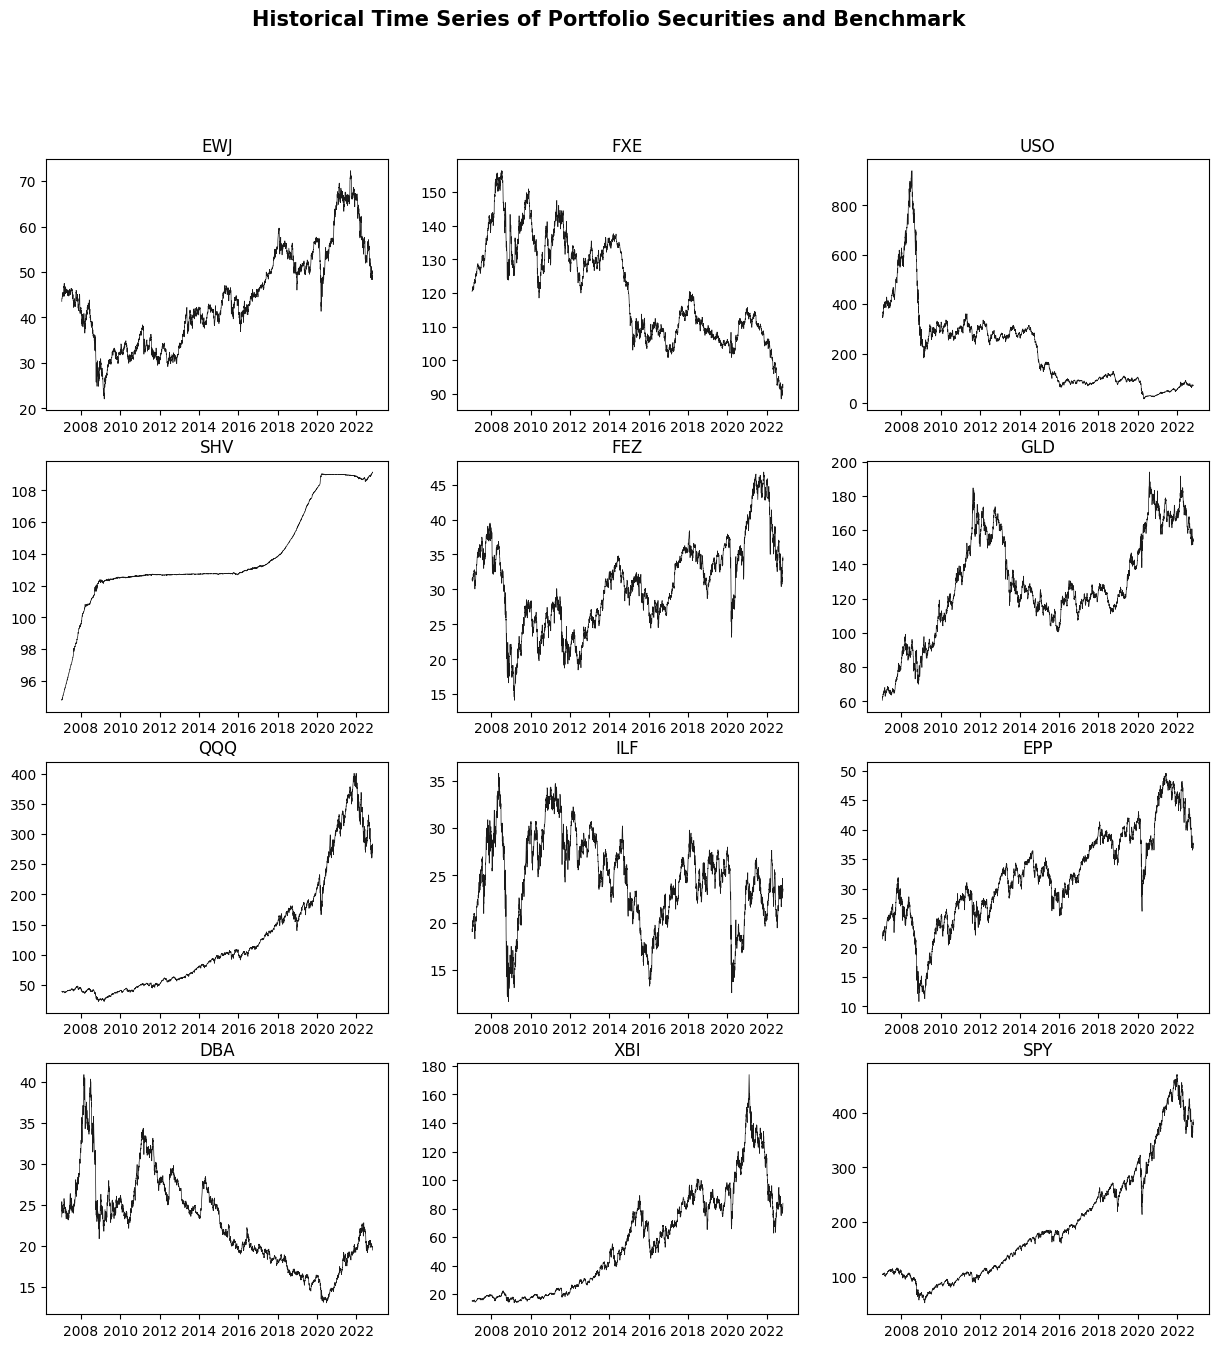

In [5]:
# Plot prices of all 12 ETFs
prices_plot, axes = plt.subplots(4,3,figsize=(15, 15))
prices_plot.suptitle('Historical Time Series of Portfolio Securities and Benchmark', fontweight='bold', fontsize=15)

ETFs = list(DATA.keys() - ['FrenchFama'])

etf_id = -1

for i in range(len(axes)):
    for j in range(len(axes[0])):
        etf_id += 1
        axes[i, j].plot(DATA[ETFs[etf_id]]['Adj Close'], 'black', linewidth=0.5, alpha=0.9)
        axes[i, j].set_title(ETFs[etf_id])


## Process French Fama data

In [6]:
# Remove last line consisting of copyright data
DATA['FrenchFama'].drop(DATA['FrenchFama'].tail(1).index ,inplace=True)

# Convert index column to datetime
DATA['FrenchFama'].index = pd.to_datetime(DATA['FrenchFama'].index)

# Crop data to relevant time period
DATA['FrenchFama'] = DATA['FrenchFama'][DATA['FrenchFama'].index > '2006-01-01']

# Display French Fama data
DATA['FrenchFama']

,Mkt-RF,SMB,HML,RF
2006-01-03,1.50,-0.20,0.16,0.017
2006-01-04,0.46,0.37,0.03,0.017
2006-01-05,0.03,0.28,-0.10,0.017
2006-01-06,0.92,0.11,-0.24,0.017
2006-01-09,0.45,0.52,-0.17,0.017
...,...,...,...,...
2022-10-25,1.78,1.35,-1.52,0.011
2022-10-26,-0.66,0.42,0.89,0.011
2022-10-27,-0.54,0.32,1.06,0.011
2022-10-28,2.33,-0.04,-0.34,0.011


# 2. Compute estimator values

## Expected returns estimator

In [7]:
def expected_returns(period):
    expected_returns_matrix = pd.DataFrame()
    
    # Get all relevant etfs
    etfs = ['SPY', 'SHV', 'XBI', 'QQQ', 'FXE', 'GLD', 'DBA', 'USO', 'ILF', 'FEZ', 'EPP', 'EWJ']
    
    # Get the adjusted close prices for all etfs in a single dataframe
    for etf in etfs:
        expected_returns_matrix[etf] = DATA[etf]['Adj Close']
    
    # Calculate returns and annualize
    expected_returns_matrix = expected_returns_matrix.pct_change(1).dropna() * 250
    
    # Calculate rolling mean
    expected_returns_matrix = expected_returns_matrix.rolling(period).mean().dropna()[0::5]

    return expected_returns_matrix


In [8]:
# Compute and store the values of expected returns for 60, 90 and 120 days
DATA['expected_returns_60'] = expected_returns(60)
DATA['expected_returns_90'] = expected_returns(90)
DATA['expected_returns_120'] = expected_returns(120)

## Covarinace matrices of returns estimator

In [9]:
def covarince_matrix_returns(period):
    returns_matrix = pd.DataFrame()
    
    # Get all relevant etfs
    etfs = ['SPY', 'SHV', 'XBI', 'QQQ', 'FXE', 'GLD', 'DBA', 'USO', 'ILF', 'FEZ', 'EPP', 'EWJ']
    
    # Get the adjusted close prices for all etfs in a single dataframe
    for etf in etfs:
        returns_matrix[etf] = DATA[etf]['Adj Close']
    
    # Calculate returns and annualize
    returns_matrix = returns_matrix.pct_change(1).dropna() * 250
    
    # Define list for covariance matrix
    covariance_matrices = []
    
    # Define starting index of window
    start = 0
    
    # Sliding through the returns data, calculate covariance values
    while start + period <= len(returns_matrix)-1:
        covariance_matrices.append(returns_matrix.reset_index().iloc[start:start+period, :].cov(numeric_only=True))
        start += 5
    
    return covariance_matrices


In [10]:
# Compute and store the values of covariance matrices for 60, 90 and 180 days
DATA['covariance_matrix_returns_60'] = covarince_matrix_returns(60)
DATA['covariance_matrix_returns_90'] = covarince_matrix_returns(90)
DATA['covariance_matrix_returns_120'] = covarince_matrix_returns(120)

## Covariance matrices of french fama factors

In [11]:
def covarince_matrix_french_fama(period):
    # French Fama data
    french_fama_data = DATA['FrenchFama'].drop(['Mkt-RF'], axis=1)
    
    # Define list for covariance matrix
    covariance_matrices = []
    
    # Define starting index of window
    start = 0
    
    # Sliding through the returns data, calculate covariance values
    while start + period <= len(french_fama_data)-1:
        covariance_matrices.append(french_fama_data.reset_index().iloc[start:start+period, :].cov(numeric_only=True))
        start += 5
    
    return covariance_matrices


In [12]:
DATA['covariance_matrix_french_fama_60'] = covarince_matrix_french_fama(60)
DATA['covariance_matrix_french_fama_90'] = covarince_matrix_french_fama(90)
DATA['covariance_matrix_french_fama_120'] = covarince_matrix_french_fama(120)

## Covariance matrices of factor model

In [13]:
def covariance_matrix(period):
    
    returns_matrix = pd.DataFrame()
    covariance_matrices = []
    
    # Get all relevant etfs
    etfs = ['SPY', 'SHV', 'XBI', 'QQQ', 'FXE', 'GLD', 'DBA', 'USO', 'ILF', 'FEZ', 'EPP', 'EWJ']
    
    # Get the adjusted close prices for all etfs in a single dataframe
    for etf in etfs:
        returns_matrix[etf] = DATA[etf]['Adj Close']
    
    # Calculate returns and annualize
    returns_matrix = returns_matrix.pct_change(1).dropna() * 250
    
    # Get French Fama covariance matrix data
    covariance_matrix_french_fama = DATA[f'covariance_matrix_french_fama_{period}']
        
    # Define starting index of window
    start = 0
    
    # Sliding through the returns data, calculate beta_im values
    while start + period <= len(returns_matrix)-1:
        
        # Get returns matrix
        returns_matrix_slice = returns_matrix.reset_index().iloc[start:start+period, :].drop("Date", axis=1)

        # Get french fama factors
        french_fama_factors_slice = pd.merge(
            returns_matrix.reset_index().iloc[start:start+period, :], 
            DATA['FrenchFama'].reset_index().rename(columns={'index':'Date'}), 
            how='inner', 
            on='Date' 
        ).loc[:, ["SMB","HML","RF"]]
        french_fama_factors_slice.index += start
        
        # Substract the rf rate from returns
        for etf in etfs:
            returns_matrix_slice[etf] -= french_fama_factors_slice["RF"]        
        
        # Get sigma_f
        sigma_f = covariance_matrix_french_fama[int(start//5)]
        
        # Perform regression
        lr = LinearRegression().fit(french_fama_factors_slice, returns_matrix_slice)
        B = lr.coef_
        
        # Predicted values
        predictions = lr.predict(french_fama_factors_slice)
        
        # Calculate residuals
        residuals = returns_matrix_slice - predictions
        
        # Calculate diagonal
        diag = np.diag(residuals.std()**2)
        
        # Calculate sigma
        sigma = B.dot(sigma_f).dot(B.T) + diag
                
        # Store sigma
        covariance_matrices.append(sigma)
                                       
        start += 5

    return covariance_matrices


In [14]:
DATA['covariance_matrix_60'] = covariance_matrix(60)
DATA['covariance_matrix_90'] = covariance_matrix(90)
DATA['covariance_matrix_120'] = covariance_matrix(120)

## Calculate Beta values

In [15]:
def beta_values(period):
    
    returns_matrix = pd.DataFrame()
    beta_values = {}
    betas = pd.DataFrame()
    
    # Get all relevant etfs
    etfs = ['SPY', 'SHV', 'XBI', 'QQQ', 'FXE', 'GLD', 'DBA', 'USO', 'ILF', 'FEZ', 'EPP', 'EWJ']
    
    # Get the adjusted close prices for all etfs in a single dataframe
    for etf in etfs:
        returns_matrix[etf] = DATA[etf]['Adj Close']
        beta_values[etf] = []
    
    # Calculate returns and annualize
    returns_matrix = returns_matrix.pct_change(1).dropna() * 250
        
    # Define starting index of window
    start = 0   
    
    # Sliding through the returns data, calculate beta_im values
    while start + period <= len(returns_matrix)-1:
        
        # Merges Returns data and french-fama factors to perform regression
        returns_french_fama = pd.merge(
            returns_matrix.reset_index().iloc[start:start+period, :], 
            DATA['FrenchFama'].reset_index().rename(columns={'index':'Date'}), 
            how='inner', 
            on='Date'
        )
                
        # Extract french fama factors
        french_fama_factors = np.array([returns_french_fama['Mkt-RF'], returns_french_fama['SMB'], returns_french_fama['HML']]).T
                
        # For each security
        for etf in etfs:
            # Calculate risk free returns
            returns_french_fama[f'{etf}_ri'] = returns_french_fama[etf] - returns_french_fama['RF']
            
            # Perform regression of factors on risk-free returns
            lr = LinearRegression().fit(french_fama_factors, returns_french_fama[f'{etf}_ri'])
            
            # Get coeffecients and intercept values
            alpha = lr.intercept_
            B = lr.coef_
                        
            # Calculate residuals
            epsilon = returns_french_fama[f'{etf}_ri'] - (french_fama_factors.dot(B))

            # Calculate r_m
            r_m = returns_french_fama['SPY']

            # Calculate r_i
            r_i = returns_french_fama['RF'] + (B[0]**3)*returns_french_fama['SMB'] + B[1]*returns_french_fama['SMB'] + B[2]*returns_french_fama['HML'] + alpha + epsilon
            
            # Calculte beta_im
            beta_im = np.cov(r_i,r_m)[0][1] / np.var(r_m,ddof=1)
            
            # Store beta_im
            beta_values[etf].append(beta_im)
        
        start += 5
        
    # Create dataframe of beta values
    for etf in etfs:
        betas[etf] = beta_values[etf]
    
    return betas


In [16]:
# Compute and store the values of betas for 60, 90 and 180 days
DATA['beta_values_60'] = beta_values(60)
DATA['beta_values_90'] = beta_values(90)
DATA['beta_values_120'] = beta_values(120)

## Annualized percentage returns of all etfs

In [17]:
def returns_values(period):
    
    returns_matrix = pd.DataFrame()
    returns = []
    
    # Get all relevant etfs
    etfs = ['SPY', 'SHV', 'XBI', 'QQQ', 'FXE', 'GLD', 'DBA', 'USO', 'ILF', 'FEZ', 'EPP', 'EWJ']
    
    # Get the adjusted close prices for all etfs in a single dataframe
    for etf in etfs:
        returns_matrix[etf] = DATA[etf]['Adj Close']
    
    # Calculate returns and annualize
    returns_matrix = returns_matrix.pct_change(1).dropna() * 250
    
    # Define starting index of window
    start = 0
    
    # Sliding through the returns data, calculate beta_im values
    while start + period <= len(returns_matrix)-1:
        
        returns.append(returns_matrix.reset_index().iloc[start:start+period, :].drop(['Date'], axis=1))
        
        start += 5
        
    return returns


In [18]:
# Compute and store the values of returns for 60, 90 and 180 days
DATA['returns_values_60'] = returns_values(60)
DATA['returns_values_90'] = returns_values(90)
DATA['returns_values_120'] = returns_values(120)

# 3. Build strategy models

## First model

\begin{cases}
\max\limits_{{\omega ∈ ℝ^{n}}}\rho^{T}\omega-\lambda\sqrt{\omega^{T}\Sigma\omega}\\
-0.5\le\sum_{i=1}^{n} \beta_{i}^{m}\omega_{i}\le0.5\\
\sum_{i=1}^{n} \omega_{i}=1, -2\leq\omega_{i}\leq2
\end{cases}

In [19]:
def first_strategy(n, rho, sigma, lambda_, beta):
    # Set the variable weights
    omega = cp.Variable(n)
    
    # Compute cholesky decomposition of sigma
    L = np.linalg.cholesky(sigma)

    # Define objective funtion to minimize
    objective = (lambda_ * cp.norm(L@omega, 2)) - (rho.T @ omega)
    
    e = np.ones(n)
    
    # Define constraints
    constraints = [
        beta @ omega.T <= 0.5,
        -1 * (beta @ omega.T) <= 0.5,
        e @ omega.T == 1,
        omega <= [2 for i in range(n)],
        -1 * omega <= [2 for i in range(n)]
    ]
    
    # Solve problem and get optimal weights
    prob = cp.Problem(cp.Minimize(objective), constraints)
    result = prob.solve()
    
    return omega.value


## Second model

\begin{cases}
\max\limits_{{\omega ∈ ℝ^{n}}}\frac{\rho^{T}\omega}{TEV(\omega)} -\lambda\sqrt{\omega^{T}\Sigma\omega}\\
-1\le\sum_{i=1}^{n} \beta_{i}^{m}\omega_{i}\le2\\
\sum_{i=1}^{n} \omega_{i}=1, -2\leq\omega_{i}\leq2
\end{cases}

In [20]:
def second_strategy(n, rho, sigma, lambda_, beta, returns_matrix):
    
    # Define objective to minimize
    def objective(omega):
        TEV = np.std((np.array(returns_matrix) @ omega) - returns_matrix['SPY'])
        return (lambda_ * np.sqrt(omega.T @ sigma @ omega)) - ((rho.T @ omega)/TEV)
    
    # Define contstaints
    non_linear_constraint = lambda x: np.sum(beta @ x.T) 
    non_linear_constraint = NonlinearConstraint(non_linear_constraint, -1, 2)
    constraints = ({
                    'type':'eq',
                    'fun': lambda x: np.sum(x) - 1.0
                   },
                   non_linear_constraint)
    bounds = ((-2, 2),)*12
    
    # Set initial value of omega
    x0 = np.asarray([1/12]*12)
    
    # Run optimization to get weights
    result = minimize(objective, x0, method='SLSQP', constraints=constraints, bounds=bounds)
    
    return result['x']


# 4. Executing chosen strategies on both models

In [21]:
def execute_strategies(n, lambda_, covariance_period, expected_returns_period):
    
    # Set DATA storage
    DATA[f'Model1_Strategy_{expected_returns_period}^{covariance_period}_l{lambda_}'] = []
    DATA[f'Model2_Strategy_{expected_returns_period}^{covariance_period}_l{lambda_}'] = []

    # Get required data for portfolio optimizations
    covariance_matrices = DATA[f'covariance_matrix_{covariance_period}']
    expected_returns_vectors = DATA[f'expected_returns_{expected_returns_period}']    
    betas_vectors = DATA[f'beta_values_{expected_returns_period}']
    returns_matrices = DATA[f'returns_values_{expected_returns_period}']
    
    # Ensure same starting mark for both periods
    covariance_matrices = covariance_matrices[int(((math.lcm(covariance_period, expected_returns_period) - covariance_period)/5)):]
    expected_returns_vectors = expected_returns_vectors[int((math.lcm(covariance_period, expected_returns_period) - expected_returns_period)/5):]
    betas_vectors = betas_vectors[int((math.lcm(covariance_period, expected_returns_period) - expected_returns_period)/5):]
    returns_matrices = returns_matrices[int((math.lcm(covariance_period, expected_returns_period) - expected_returns_period)/5):]    
    
    for i in range(len(expected_returns_vectors)):
            DATA[f'Model1_Strategy_{expected_returns_period}^{covariance_period}_l{lambda_}'].append(
                first_strategy(
                    n, 
                    np.array(expected_returns_vectors.iloc[i]), 
                    np.array(covariance_matrices[i]), 
                    lambda_, 
                    np.array(betas_vectors.iloc[i])
                )
            )
            DATA[f'Model2_Strategy_{expected_returns_period}^{covariance_period}_l{lambda_}'].append(
                second_strategy(
                    n, 
                    np.array(expected_returns_vectors.iloc[i]), 
                    np.array(covariance_matrices[i]), 
                    lambda_, 
                    np.array(betas_vectors.iloc[i]),
                    returns_matrices[i]
                )
            )


## Compute weights of portfolios for all strategies

In [22]:
# Run all strategy combinations on both models and compute weights
investment_periods = [60, 90, 120]
lambdas = [0.5, 0.75, 1.0]

n = len(asset_list)

# For each strategy combination
for expected_returns_period in investment_periods:
    for covariance_matrix_period in investment_periods:
        for lambda_ in lambdas:
            print("Running strategy", expected_returns_period, covariance_matrix_period, lambda_)
            execute_strategies(n, lambda_, expected_returns_period, covariance_matrix_period)
            print("DONE")


Running strategy 60 60 0.5
DONE
Running strategy 60 60 0.75
DONE
Running strategy 60 60 1.0
DONE
Running strategy 60 90 0.5
DONE
Running strategy 60 90 0.75
DONE
Running strategy 60 90 1.0
DONE
Running strategy 60 120 0.5
DONE
Running strategy 60 120 0.75
DONE
Running strategy 60 120 1.0
DONE
Running strategy 90 60 0.5
DONE
Running strategy 90 60 0.75
DONE
Running strategy 90 60 1.0
DONE
Running strategy 90 90 0.5
DONE
Running strategy 90 90 0.75
DONE
Running strategy 90 90 1.0
DONE
Running strategy 90 120 0.5
DONE
Running strategy 90 120 0.75
DONE
Running strategy 90 120 1.0
DONE
Running strategy 120 60 0.5
DONE
Running strategy 120 60 0.75
DONE
Running strategy 120 60 1.0
DONE
Running strategy 120 90 0.5
DONE
Running strategy 120 90 0.75
DONE
Running strategy 120 90 1.0
DONE
Running strategy 120 120 0.5
DONE
Running strategy 120 120 0.75
DONE
Running strategy 120 120 1.0
DONE


## Store weights for all strategies

In [23]:
investment_periods = [60, 90, 120]
lambdas = [0.5, 0.75, 1.0]

# For each strategy combination, store weights
for expected_returns_period in investment_periods:
    for covariance_matrix_period in investment_periods:
        for lambda_ in lambdas:
            pd.DataFrame(DATA[f'Model1_Strategy_{expected_returns_period}^{covariance_matrix_period}_l{lambda_}']).to_csv(f'./Weights/Model1_Strategy_{expected_returns_period}^{covariance_matrix_period}_l{lambda_}.csv', index=False)
            pd.DataFrame(DATA[f'Model2_Strategy_{expected_returns_period}^{covariance_matrix_period}_l{lambda_}']).to_csv(f'./Weights/Model2_Strategy_{expected_returns_period}^{covariance_matrix_period}_l{lambda_}.csv', index=False)


# 5. Backtesting strategies

In [24]:
def backtest(model, lambda_, covariance_period, expected_returns_period):    
    # Create returns matrix
    returns_matrix = pd.DataFrame()

    # Get all relevant etfs
    etfs = ['SPY', 'SHV', 'XBI', 'QQQ', 'FXE', 'GLD', 'DBA', 'USO', 'ILF', 'FEZ', 'EPP', 'EWJ']

    # Get the adjusted close prices for all etfs in a single dataframe
    for etf in etfs:
        returns_matrix[etf] = DATA[etf]['Adj Close']

    # Calculate returns and annualize
    returns_matrix = returns_matrix.pct_change(1).dropna() * 250
    
    # Get weekly portfolio weights
    weekly_weights_vectors = DATA[f'Model{model}_Strategy_{expected_returns_period}^{covariance_period}_l{lambda_}']
    
    # Get expected returns vectors for the timeperiod
    expected_returns_vectors = DATA[f'expected_returns_{expected_returns_period}'][int((math.lcm(covariance_period, expected_returns_period) - expected_returns_period)/5):]
    
    # Modify to daily portfolio weights
    daily_weights_vectors = [w for w in weekly_weights_vectors for _ in range(5)]
    daily_weights_vectors.pop()
    
    # Modify time period of returns matrix to match dates in expected returns vector
    returns_matrix = returns_matrix[returns_matrix.index >= expected_returns_vectors.index[0]]
    
    # Returns dates
    DATA[f'Model{model}_Strategy_{expected_returns_period}^{covariance_period}_l{lambda_}_portfolio_daily_returns_dates'] = returns_matrix.index
    
    # Initialize backtest data
    DATA[f'Model{model}_Strategy_{expected_returns_period}^{covariance_period}_l{lambda_}_portfolio_daily_returns'] = []
    
    print(f'Model{model}_Strategy_{expected_returns_period}^{covariance_period}_l{lambda_}_portfolio_daily_returns')
    
    for i in range(len(daily_weights_vectors)):
        DATA[f'Model{model}_Strategy_{expected_returns_period}^{covariance_period}_l{lambda_}_portfolio_daily_returns'].append(
            np.array(daily_weights_vectors[i]) @ np.array(returns_matrix.iloc[i]).T
        )


## Run backtests for all strategies

In [25]:
# Backtest all strategy combinations on both models
investment_periods = [60, 90, 120]
lambdas = [0.5, 0.75, 1.0]
models = [1, 2]

n = len(asset_list)

# For each strategy combination
for model in models:
    for expected_returns_period in investment_periods:
        for covariance_matrix_period in investment_periods:
            for lambda_ in lambdas:
                backtest(model, lambda_, covariance_matrix_period, expected_returns_period)


Model1_Strategy_60^60_l0.5_portfolio_daily_returns
Model1_Strategy_60^60_l0.75_portfolio_daily_returns
Model1_Strategy_60^60_l1.0_portfolio_daily_returns
Model1_Strategy_60^90_l0.5_portfolio_daily_returns
Model1_Strategy_60^90_l0.75_portfolio_daily_returns
Model1_Strategy_60^90_l1.0_portfolio_daily_returns
Model1_Strategy_60^120_l0.5_portfolio_daily_returns
Model1_Strategy_60^120_l0.75_portfolio_daily_returns
Model1_Strategy_60^120_l1.0_portfolio_daily_returns
Model1_Strategy_90^60_l0.5_portfolio_daily_returns
Model1_Strategy_90^60_l0.75_portfolio_daily_returns
Model1_Strategy_90^60_l1.0_portfolio_daily_returns
Model1_Strategy_90^90_l0.5_portfolio_daily_returns
Model1_Strategy_90^90_l0.75_portfolio_daily_returns
Model1_Strategy_90^90_l1.0_portfolio_daily_returns
Model1_Strategy_90^120_l0.5_portfolio_daily_returns
Model1_Strategy_90^120_l0.75_portfolio_daily_returns
Model1_Strategy_90^120_l1.0_portfolio_daily_returns
Model1_Strategy_120^60_l0.5_portfolio_daily_returns
Model1_Strategy_12

# Store all backtest returns

In [26]:
# Backtest all strategy combinations on both models
investment_periods = [60, 90, 120]
lambdas = [0.5, 0.75, 1.0]
models = [1, 2]

n = len(asset_list)

# For each strategy combination
for expected_returns_period in investment_periods:
    for covariance_matrix_period in investment_periods:
        for lambda_ in lambdas:
            df_temp = pd.DataFrame()
            df_temp['Date'] = DATA[f'Model1_Strategy_{expected_returns_period}^{covariance_matrix_period}_l{lambda_}_portfolio_daily_returns_dates']
            for model in models:
#                 print(f'Model{model}_Strategy_{expected_returns_period}^{covariance_matrix_period}_l{lambda_}_portfolio_daily_returns')
                df_temp[f'Model{model}_Strategy_{expected_returns_period}^{covariance_matrix_period}_l{lambda_}_portfolio_daily_returns'] = DATA[f'Model{model}_Strategy_{expected_returns_period}^{covariance_matrix_period}_l{lambda_}_portfolio_daily_returns']
                df_temp.to_csv(f'./Backtests/Strategy_{expected_returns_period}^{covariance_matrix_period}_l{lambda_}_portfolio_daily_returns.csv', index=False)


# 6. Analyze results

## Load returns data

In [27]:
backtest_returns = {}

investment_periods = [60, 90, 120]
lambdas = [0.5, 0.75, 1.0]
models = [1, 2]

count = 1

# For each strategy combination
for expected_returns_period in investment_periods:
    for covariance_matrix_period in investment_periods:
        for lambda_ in lambdas:
            df = pd.read_csv(f'./Backtests/Strategy_{expected_returns_period}^{covariance_matrix_period}_l{lambda_}_portfolio_daily_returns.csv')
            df.index = pd.to_datetime(df['Date'])
            for model in models:
                print(f'{count}. Model{model}_Strategy_{expected_returns_period}^{covariance_matrix_period}_l{lambda_}_portfolio_daily_returns')
                backtest_returns[f'Model{model}_Strategy_{expected_returns_period}^{covariance_matrix_period}_l{lambda_}_portfolio_daily_returns'] = df[f'Model{model}_Strategy_{expected_returns_period}^{covariance_matrix_period}_l{lambda_}_portfolio_daily_returns']
                count += 1


1. Model1_Strategy_60^60_l0.5_portfolio_daily_returns
2. Model2_Strategy_60^60_l0.5_portfolio_daily_returns
3. Model1_Strategy_60^60_l0.75_portfolio_daily_returns
4. Model2_Strategy_60^60_l0.75_portfolio_daily_returns
5. Model1_Strategy_60^60_l1.0_portfolio_daily_returns
6. Model2_Strategy_60^60_l1.0_portfolio_daily_returns
7. Model1_Strategy_60^90_l0.5_portfolio_daily_returns
8. Model2_Strategy_60^90_l0.5_portfolio_daily_returns
9. Model1_Strategy_60^90_l0.75_portfolio_daily_returns
10. Model2_Strategy_60^90_l0.75_portfolio_daily_returns
11. Model1_Strategy_60^90_l1.0_portfolio_daily_returns
12. Model2_Strategy_60^90_l1.0_portfolio_daily_returns
13. Model1_Strategy_60^120_l0.5_portfolio_daily_returns
14. Model2_Strategy_60^120_l0.5_portfolio_daily_returns
15. Model1_Strategy_60^120_l0.75_portfolio_daily_returns
16. Model2_Strategy_60^120_l0.75_portfolio_daily_returns
17. Model1_Strategy_60^120_l1.0_portfolio_daily_returns
18. Model2_Strategy_60^120_l1.0_portfolio_daily_returns
19. Mod

## Divide into periods

In [28]:
investment_periods = [60, 90, 120]
lambdas = [0.5, 0.75, 1.0]
models = [1, 2]
# For each period and strategy combination
for expected_returns_period in investment_periods:
    for covariance_matrix_period in investment_periods:
        for lambda_ in lambdas:
            for model in models:
                backtest_returns[f'Period1_Model{model}_Strategy_{expected_returns_period}^{covariance_matrix_period}_l{lambda_}_portfolio_daily_returns'] = backtest_returns[f'Model{model}_Strategy_{expected_returns_period}^{covariance_matrix_period}_l{lambda_}_portfolio_daily_returns']['2007-03-01':'2008-12-31']
                backtest_returns[f'Period2_Model{model}_Strategy_{expected_returns_period}^{covariance_matrix_period}_l{lambda_}_portfolio_daily_returns'] = backtest_returns[f'Model{model}_Strategy_{expected_returns_period}^{covariance_matrix_period}_l{lambda_}_portfolio_daily_returns']['2009-01-01':'2009-12-31']
                backtest_returns[f'Period3_Model{model}_Strategy_{expected_returns_period}^{covariance_matrix_period}_l{lambda_}_portfolio_daily_returns'] = backtest_returns[f'Model{model}_Strategy_{expected_returns_period}^{covariance_matrix_period}_l{lambda_}_portfolio_daily_returns']['2010-01-01':'2019-12-31']
                backtest_returns[f'Period4_Model{model}_Strategy_{expected_returns_period}^{covariance_matrix_period}_l{lambda_}_portfolio_daily_returns'] = backtest_returns[f'Model{model}_Strategy_{expected_returns_period}^{covariance_matrix_period}_l{lambda_}_portfolio_daily_returns']['2020-01-01':'2020-12-31']
                backtest_returns[f'Period5_Model{model}_Strategy_{expected_returns_period}^{covariance_matrix_period}_l{lambda_}_portfolio_daily_returns'] = backtest_returns[f'Model{model}_Strategy_{expected_returns_period}^{covariance_matrix_period}_l{lambda_}_portfolio_daily_returns']['2021-01-01':'2022-01-31']
                backtest_returns[f'Period6_Model{model}_Strategy_{expected_returns_period}^{covariance_matrix_period}_l{lambda_}_portfolio_daily_returns'] = backtest_returns[f'Model{model}_Strategy_{expected_returns_period}^{covariance_matrix_period}_l{lambda_}_portfolio_daily_returns']['2022-02-01':'2022-10-31']
backtest_returns['Period1_SPY_returns'] = DATA['SPY']['Adj Close']['2007-03-01':'2008-12-31'].pct_change(1).dropna() * 250
backtest_returns['Period2_SPY_returns'] = DATA['SPY']['Adj Close']['2009-01-01':'2009-12-31'].pct_change(1).dropna() * 250
backtest_returns['Period3_SPY_returns'] = DATA['SPY']['Adj Close']['2010-01-01':'2019-12-31'].pct_change(1).dropna() * 250
backtest_returns['Period4_SPY_returns'] = DATA['SPY']['Adj Close']['2020-01-01':'2020-12-31'].pct_change(1).dropna() * 250
backtest_returns['Period5_SPY_returns'] = DATA['SPY']['Adj Close']['2021-01-01':'2022-01-31'].pct_change(1).dropna() * 250
backtest_returns['Period6_SPY_returns'] = DATA['SPY']['Adj Close']['2022-02-01':'2022-10-31'].pct_change(1).dropna() * 250


## Calculate and store metrics

In [29]:
metrics = pd.DataFrame()

In [30]:
investment_periods = [60, 90, 120]
lambdas = [0.5, 0.75, 1.0]
models = [1, 2]
periods = [1, 2, 3, 4, 5, 6]

Names = []
Annual_volatility=[]
Annual_return=[]
Sharpe_ratio=[]
kurtosis_=[]
Skewness_=[]
Max_Drawdown=[]
C_Var=[]
Var=[]
mean_daily_return=[]
geometric_daily_return=[]

# For each period and strategy combination
for expected_returns_period in investment_periods:
    for covariance_matrix_period in investment_periods:
        for lambda_ in lambdas:
            for model in models:
                for period in periods:
                    modified_returns = backtest_returns[f'Period{period}_Model{model}_Strategy_{expected_returns_period}^{covariance_matrix_period}_l{lambda_}_portfolio_daily_returns']/100
                    Annual_volatility.append((ep.annual_volatility(modified_returns)*100))
                    Annual_return.append(ep.annual_return(modified_returns)*100)
                    Sharpe_ratio.append(ep.sharpe_ratio(modified_returns))
                    kurtosis_.append(kurtosis(modified_returns))
                    Skewness_.append(skew(modified_returns))
                    Max_Drawdown.append(ep.max_drawdown(modified_returns))
                    C_Var.append(ep.conditional_value_at_risk(modified_returns))
                    Var.append(ep.value_at_risk(modified_returns))
                    mean_daily_return.append(np.mean(modified_returns))
                    geometric_daily_return.append(((np.prod(modified_returns)**2)**(1/2))**(1/len(modified_returns)))
                    Names.append(f'Period{period}_Model{model}_Strategy_{expected_returns_period}^{covariance_matrix_period}_l{lambda_}')

for period in periods:
    modified_returns = backtest_returns[f'Period{period}_SPY_returns']/100
    Annual_volatility.append((ep.annual_volatility(modified_returns)*100))
    Annual_return.append(ep.annual_return(modified_returns)*100)
    Sharpe_ratio.append(ep.sharpe_ratio(modified_returns))
    kurtosis_.append(kurtosis(modified_returns))
    Skewness_.append(skew(modified_returns))
    Max_Drawdown.append(ep.max_drawdown(modified_returns))
    C_Var.append(ep.conditional_value_at_risk(modified_returns))
    Var.append(ep.value_at_risk(modified_returns))
    mean_daily_return.append(np.mean(modified_returns))
    geometric_daily_return.append(((np.prod(modified_returns)**2)**(1/2))**(1/len(modified_returns)))
    Names.append(f'Period{period}_SPY_returns')


In [31]:
metrics['Name'] = Names
metrics['Annual_volatility']=Annual_volatility
metrics['Annual_return']=Annual_return
metrics['Sharpe_ratio']=Sharpe_ratio
metrics['kurtosis']=kurtosis_
metrics['Skewness']=Skewness_
metrics['Max_Drawdown']=Max_Drawdown
metrics['C_Var']=C_Var
metrics['Var']=Var
metrics['mean_daily_return']=mean_daily_return
metrics['geometric_daily_return']=geometric_daily_return
metrics

,Name,Annual_volatility,Annual_return,Sharpe_ratio,kurtosis,Skewness,Max_Drawdown,C_Var,Var,mean_daily_return,geometric_daily_return
0,Period1_Model1_Strategy_60^60_l0.5,92.436396,-40.559582,-0.035045,36.032073,-1.417924,-0.826451,-0.150184,-0.045769,-0.000129,0.0
1,Period2_Model1_Strategy_60^60_l0.5,88.705197,52.989423,0.894502,40.310537,3.015409,-0.456182,-0.105368,-0.031797,0.003149,0.0
2,Period3_Model1_Strategy_60^60_l0.5,48.557835,-2.302781,0.218019,85.358982,-2.170535,-0.812889,-0.062969,-0.017717,0.000420,0.0
3,Period4_Model1_Strategy_60^60_l0.5,112.874555,151.876219,1.329797,63.765684,4.538213,-0.476151,-0.101025,-0.022264,0.005956,0.0
4,Period5_Model1_Strategy_60^60_l0.5,64.240311,71.083399,1.145833,25.321743,1.935056,-0.378037,-0.081014,-0.028910,0.002921,0.0
...,...,...,...,...,...,...,...,...,...,...,...
325,Period2_SPY_returns,66.314831,46.377998,0.905172,2.077567,0.062984,-0.567898,-0.094688,-0.070334,0.002382,0.0
326,Period3_SPY_returns,36.730960,31.078398,0.922058,4.382756,-0.425370,-0.437682,-0.057569,-0.038099,0.001344,0.0
327,Period4_SPY_returns,83.634152,19.517861,0.643696,7.127195,-0.599096,-0.683184,-0.136199,-0.079061,0.002136,0.0
328,Period5_SPY_returns,33.706285,58.199895,1.530379,0.559520,-0.260343,-0.228434,-0.047862,-0.034086,0.002047,0.0


In [32]:
metrics.to_csv('./metrics.csv')

## Create and store visualizations

In [33]:
cumulative_returns = {}

def get_cumulative_returns(returns):
    cumulative_returns = [100]
    
    pnl = 100
    
    df_cumulative_returns = pd.DataFrame()
    df_cumulative_returns.index = pd.concat([pd.Series([returns.index[0] - datetime.timedelta(days=1)]), pd.Series(returns.index)], ignore_index=True)
    
    # print(returns.index[0] - datetime.timedelta(days=1), returns.index[0])
    
    for r in returns/100:
        pnl *= (1 + r)
        cumulative_returns.append(pnl)
    
    df_cumulative_returns['cumulative_returns'] = cumulative_returns
    
    return df_cumulative_returns

for expected_returns_period in investment_periods:
    for covariance_matrix_period in investment_periods:
        for lambda_ in lambdas:
            for model in models:
                for period in periods:
                    cumulative_returns[f'Period{period}_Model{model}_Strategy_{expected_returns_period}^{covariance_matrix_period}_l{lambda_}_cumulative_daily_returns'] = get_cumulative_returns(backtest_returns[f'Period{period}_Model{model}_Strategy_{expected_returns_period}^{covariance_matrix_period}_l{lambda_}_portfolio_daily_returns'])

for period in periods:
    cumulative_returns[f'Period{period}_SPY_returns'] = get_cumulative_returns(backtest_returns[f'Period{period}_SPY_returns'])


In [34]:
cumulative_returns[f'Period2_Model1_Strategy_60^60_l0.5_cumulative_daily_returns']['cumulative_returns']
cumulative_returns[f'Period2_SPY_returns']['cumulative_returns']

2009-01-04    100.000000
2009-01-05     99.704082
2009-01-06    101.368474
2009-01-07     93.776927
2009-01-08     94.733643
                 ...    
2009-12-24    149.618866
2009-12-28    150.416994
2009-12-29    149.883362
2009-12-30    149.750010
2009-12-31    146.156843
Name: cumulative_returns, Length: 252, dtype: float64

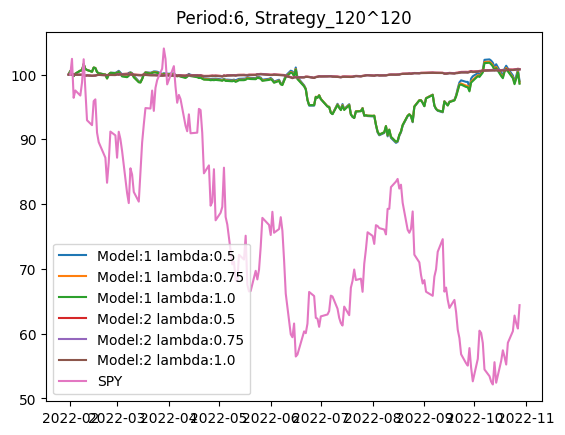

In [35]:
# Generate graphs
investment_periods = [60, 90, 120]
lambdas = [0.5, 0.75, 1.0]
models = [1, 2]
periods = [1, 2, 3, 4, 5, 6]

for period in periods:
    for expected_returns_period in investment_periods:
        for covariance_matrix_period in investment_periods:
            plt.clf()
            plt.title(f'Period:{period}, Strategy_{expected_returns_period}^{covariance_matrix_period}')
            for model in models:
                for lambda_ in lambdas:
                    plt.plot(cumulative_returns[f'Period{period}_Model{model}_Strategy_{expected_returns_period}^{covariance_matrix_period}_l{lambda_}_cumulative_daily_returns']['cumulative_returns'], label=f'Model:{model} lambda:{lambda_}')
            plt.plot(cumulative_returns[f'Period{period}_SPY_returns'][cumulative_returns[f'Period{period}_SPY_returns'].index >= cumulative_returns[f'Period{period}_Model{model}_Strategy_{expected_returns_period}^{covariance_matrix_period}_l{lambda_}_cumulative_daily_returns'].index[0]]['cumulative_returns'], label='SPY')
            plt.legend()
            plt.savefig(f'./Graphs/Period{period}_Model{model}_Strategy_{expected_returns_period}^{covariance_matrix_period}')
